#                              Biomedical Image Processing
##                 Detection and Classification of  Brain Tumor by Deep Learing   

### Aim: To detect and classify 3 major types of Brain Tumor by Image processing technique.

#### Methedology:
1. Importing the required Packages
2. Data Preprocessing
3. Data Augumentation
4. Model Building(ResNet)
5. Validation
6. Passing the test set and looking for accuracy.  

In [1]:
# Basic Packages
import keras
from skimage import io
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.simplefilter("ignore")
import cv2

# Packages for preprocessing and augumentation
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator
import imutils
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.morphology import selem
from skimage import transform as tf
selem = selem.disk(3)
from skimage.transform import rotate, AffineTransform, warp

# Model Building Packages
import resnet
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *
from skimage import io
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, load_model

# Packages for Metrics calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score

Using TensorFlow backend.
C:\Users\anish\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anish\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anish\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anish\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Functions for Data Preprocessing and Augumentation:
def Preprocess_img(img):
    img = cv2.resize(img,(150,150))
    img= 255-img
    
    return img

def Augumentation (img,trainmode="train"):

    image=[]
    flip=  np.fliplr(img) # flip right-left
    image.append(flip)

    #rotation
    rotated = rotate(img, angle=45, mode = 'wrap')
    image.append(rotated)

    #scaling
    scale_zoom_out = AffineTransform(scale=(1.5,1.5))
    wrapShift_out = warp(img,scale_zoom_out,mode='wrap')
    image.append(wrapShift_out)

    scale_zoom_in = AffineTransform(scale=(0.7,0.7))
    wrapShift_in = warp(img,scale_zoom_in,mode='wrap')
    image.append(wrapShift_in)

    #traslation
    translation_transform = AffineTransform(translation= (25,25))
    translated_image = warp(img, translation_transform, mode="wrap")
    image.append(translated_image)
    
    for i in image:
        i=img
    
    return img


In [3]:
Dataset_path=r'E:\Ani\self\AI Traid\Project\archive_edited\Training'
Dataset_path1=r'E:\Ani\self\AI Traid\Project\archive_edited\Testing'

In [4]:
# Requisites for ResNet model
img_channels =1
img_rows = 150
img_cols= 150
nb_classes = 4

In [5]:
# Class to fetch the data, Preprocess the data and Augument the data (training data)
class AugumentedDataGenerator(keras.utils.Sequence):
    "Generate Data From Keras"
    def __init__(self, trainmode="train", testmode="test", ablation =None, disease_cls = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"],
                 batch_size= 16, dim=(512,512), dim1= (150,150), n_channels=1, shuffle= True):
        "Initialization"
        self.dim1 = dim1
        self.batch_size= batch_size
        self.labels= {}
        self.list_IDs=[]
        self.trainmode = trainmode
        self.testmode=testmode
        
        
        # Fetching the data
        for i, cls in enumerate(disease_cls):
            train_path= glob.glob(os.path.join(Dataset_path, cls, "*"))

            brk_point = int(len(train_path)*0.7)
            if self.trainmode== "train":
                paths = train_path[:brk_point]
                
            if self.testmode== "test":
                paths = train_path[brk_point:]
                
            else:
                print ("error")
                    
            if ablation is not None:               
                paths= paths[:int(len(paths)*ablation/100)]
            self.list_IDs+=paths
            self.labels.update({p:i for p in paths})
          

        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        "denotesthe number of batches per epoch"
        return int (np.floor(len(self.list_IDs)/ self.batch_size))

    def __getitem__(self, index):
        "Generate 1 batch of the data"

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp =[self.list_IDs[k] for k in indexes]
        

        X,y = self._data_generation(list_IDs_temp)
        

        return X,y
        

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes= np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _data_generation(self, list_IDs_temp):
        "Generate data containig batch size samples" # X : (n_samples, *dim, n_channels)
        #Initialization
        X= np.empty((self.batch_size, *self.dim1, self.n_channels))
        y= np.empty((self.batch_size), dtype= int)

        delete_rows= []
       
        #Data Generation, Preprocessing
                
        for i , ID in enumerate(list_IDs_temp):
            img= io.imread(ID)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )   
            img=cv2.resize(img,(150,150))       
            
            if img.shape== (150,150):
                img = Preprocess_img(img)
                if self.trainmode=="train":
                    #Augumentation(only for training data)
                    img = Augumentation(img,self.trainmode)
                
                X[i,]= img[:,:,np.newaxis]
                y[i]= self.labels[ID]
                
            else:
                delete_rows.append(i)
                continue

        X= np.delete(X, delete_rows, axis=0)
        y= np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes= self.n_classes)

### ResNet Model

In [6]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.summary()









__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 75, 75, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
ma

#### ResNet model with SGD optimizer

In [7]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)

model.compile(loss= "categorical_crossentropy",  optimizer = "SGD", metrics = ["accuracy"] )

training_generator= AugumentedDataGenerator("train", ablation=20)
validation_generator= AugumentedDataGenerator("test", ablation=20)
checkpoint = ModelCheckpoint("AKA_AItriad.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.fit_generator(generator= training_generator,validation_data = validation_generator,
                    epochs=20,callbacks= [checkpoint])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
11/11 [==============================] - 52s 5s/step - loss: 2.3220 - acc: 0.3239 - val_loss: 2.1478 - val_acc: 0.6420

Epoch 00001: val_acc improved from -inf to 0.64205, saving model to AKA_AItriad.h5
Epoch 2/20
11/11 [==============================] - 44s 4s/step - loss: 2.0993 - acc: 0.6080 - val_loss: 2.0240 - val_acc: 0.7557

Epoch 00002: val_acc improved from 0.64205 to 0.75568, saving model to AKA_AItriad.h5
Epoch 3/20
11/11 [==============================] - 45s 4s/step - loss: 2.0404 - acc: 0.6932 - val_loss: 1.9554 - val_acc: 0.7955

Epoch 00003: val_acc improved from 0.75568 to 0.79545, saving model to AKA_AItriad.h5
Epoch 4/20
11/11 [==============================] - 47s 4s/step - loss: 1.9572 - acc: 0.7500 - val_loss: 1.8894 - val_acc: 0.8011

Epoch 00004: val_acc improved from 0.79545 to 0.80114, saving model to AKA_AItriad.h5
Epoch 5/20
11/11 [======================

##### Training accuracy: 94% and Validation accuracy: 93% with ; loss= categorical_crossentropy,  optimizer = SGD, metrics = accuracy
    - The model weights are saved to AKA_AItriad.h5 file.

#### ResNet model with SGD optimizer and ROC callback

In [34]:
class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs["val_auc"]=0
        
    def on_epoch_end(self, epoch, logs={}):
        y_p=[]
        y_v=[]
        for i in range(len(validation_generator)):
            x_val,y_val=validation_generator[i]
            y_pred=self.model.predict(x_val)
            y_p=+y_pred
            y_v=+y_val
            y_p = np.concatenate(y_p)
            y_v = np.concatenate(y_v)
            roc_auc = roc_auc_score(y_v, y_p)
            print("\nVal AUC for epcoch {}: {}".format(epoch, roc_auc))
            logs["val_auc"]=roc_auc

In [36]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss= "categorical_crossentropy",  optimizer = "SGD", metrics = ["accuracy"] )

training_generator= AugumentedDataGenerator("train", ablation=20)
validation_generator= AugumentedDataGenerator("test", ablation=20)

auc_logger= roc_callback()

checkpoint = ModelCheckpoint("AKA1_AItriad.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.fit_generator(generator= training_generator,validation_data = validation_generator, epochs=20, callbacks= [checkpoint,auc_logger])

Epoch 1/20
11/11 [==============================] - 77s 7s/step - loss: 2.2795 - acc: 0.3125 - val_loss: 2.1501 - val_acc: 0.4886

Epoch 00001: val_acc improved from -inf to 0.48864, saving model to AKA1_AItriad.h5

Val AUC for epcoch 0: 0.7760416666666667

Val AUC for epcoch 0: 0.83203125

Val AUC for epcoch 0: 0.7395833333333333

Val AUC for epcoch 0: 0.91015625

Val AUC for epcoch 0: 0.8385416666666666

Val AUC for epcoch 0: 0.6744791666666666

Val AUC for epcoch 0: 0.8177083333333334

Val AUC for epcoch 0: 0.8216145833333334

Val AUC for epcoch 0: 0.7916666666666667

Val AUC for epcoch 0: 0.8802083333333334

Val AUC for epcoch 0: 0.8151041666666666
Epoch 2/20
11/11 [==============================] - 57s 5s/step - loss: 2.1019 - acc: 0.5568 - val_loss: 2.0210 - val_acc: 0.5909

Epoch 00002: val_acc improved from 0.48864 to 0.59091, saving model to AKA1_AItriad.h5

Val AUC for epcoch 1: 0.8424479166666665

Val AUC for epcoch 1: 0.9283854166666666

Val AUC for epcoch 1: 0.717447916666

##### Training accuracy: 94% and Validation accuracy: 96% with ; loss= categorical_crossentropy,  optimizer = SGD, metrics = accuracy with maximum Auc score of 1. 
    - The model weights are saved to AKA1_AItriad.h5 file. 

In [10]:
#Model1: with SGD optimer
classifier = load_model('AKA_AItriad.h5')

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [37]:
#Model2: with SGD optimer ,ROC callback 
classifier_1 = load_model('AKA1_AItriad.h5')

In [12]:
model.save('AKA1_AItriad.h5')

#### Passing on the Test set to all the 3 created models.

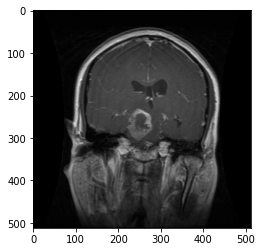

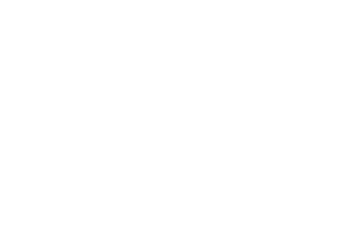

In [13]:
DATADIR = r"E:\Ani\self\AI Traid\Project\archive_edited\Testing" # Dictionary of testing data
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"] # classes
for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

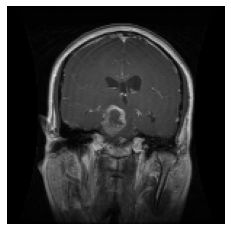

In [14]:
IMG_SIZE = 150
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array,cmap = "gray")
plt.axis("off")

In [15]:
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                testing_data.append([new_array,class_num])
            except Exception as e:
                pass
create_testing_data()

In [16]:
X_test = []
y_test = []
for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)
print((y_test))
X_test_1= np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X_test_1.shape)
X_test = X_test_1.reshape(-1,150,150,1)
print(X_test.shape)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
(90, 150, 150)
(90, 150, 150, 1)


In [17]:
X_test = []

for i in X_test_1:
    P= Preprocess_img(i)
    X_test.append(P)    
X_test=np.asarray(X_test)    
X_test = X_test.reshape(-1,150,150,1)
print(len(X_test))

90


In [18]:
# Model 1 prediction
pred=classifier.predict(X_test)
test_labels = np.argmax(pred,axis=1)
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 3 3 0 0 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 2 3 3 2 2 2 2 2 0 2 2 3 2 2 0 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [43]:
# Model 2 prediction
pred_1=classifier_1.predict(X_test)
test_labels_1 = np.argmax(pred_1,axis=1)
print(test_labels_1)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 3 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 3 3 2 2 2 1 2 1 2 2 3 2 2 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [44]:
confusion_matrix_output =confusion_matrix(y_test, test_labels) 
confusion_matrix_output_1 =confusion_matrix(y_test, test_labels_1) 

print("Model 1 \n", confusion_matrix_output)
print('\n')
print("Model 2\n",confusion_matrix_output_1)


Model 1 
 [[26  0  0  0]
 [ 4 15  0  3]
 [ 2  0 10  3]
 [ 0  0  0 27]]


Model 2
 [[25  1  0  0]
 [ 1 19  0  2]
 [ 0  3  9  3]
 [ 0  0  0 27]]


In [45]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [46]:
print ("Metrics of Model 1")
print("Accuracy:", accuracy(confusion_matrix_output))
print("Precision:" , precision_score(y_test, test_labels,pos_label='positive',average='micro'))
print("recall:", recall_score(y_test, test_labels,pos_label='positive',average='micro'))
print('\n')
print ("Metrics of Model 2")
print("Accuracy:", accuracy(confusion_matrix_output_1))
print("Precision:" , precision_score(y_test, test_labels_1,pos_label='positive',average='micro'))
print("recall:", recall_score(y_test, test_labels_1,pos_label='positive',average='micro'))

Metrics of Model 1
Accuracy: 0.8666666666666667
Precision: 0.8666666666666667
recall: 0.8666666666666667


Metrics of Model 2
Accuracy: 0.8888888888888888
Precision: 0.8888888888888888
recall: 0.8888888888888888


In [42]:
# True positive rate
sensitivity = confusion_matrix_output_1[0,0]/(confusion_matrix_output_1[0,0]+confusion_matrix_output_1[0,1])
print('Sensitivity : ', sensitivity ) 

#True negetive rate
specificity = confusion_matrix_output_1[1,1]/(confusion_matrix_output_1[1,0]+confusion_matrix_output_1[1,1])
print('Specificity : ', specificity)

Sensitivity :  0.9615384615384616
Specificity :  0.95


### Visualization:

In [24]:
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
test_set= 255-X_test # changing back to original view
predicted= np.array(test_labels)
predicted_1= np.array(test_labels_1)
actual= np.array(y_test)

Actual Label: 0 , glioma_tumor
Predicted Label: 0 , glioma_tumor
Predicted Label_ROC: 0 , glioma_tumor


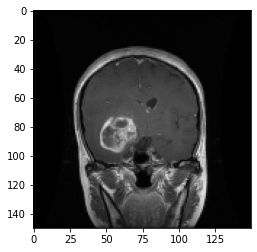

In [25]:
index=4
plt.imshow(test_set[index], cmap="gray")
print("Actual Label:",actual[index] ,",",CATEGORIES[actual[index]] )
print("Predicted Label:",predicted[index],",",CATEGORIES[predicted[index]] )
print("Predicted Label_ROC:",predicted_1[index],",",CATEGORIES[predicted_1[index]] )

In [26]:
history = model.history.history